# Load packages

In [136]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt

# Implement Network

In [137]:
class NeuralNetwork:
    """
    A simple implementation of a Neural Network with support for multiple layers.

    Attributes:
        layers (list): A list of integers representing the number of nodes in each layer.
        weights (list): A list of numpy arrays representing the weights between each layer.
        biases (list): A list of numpy arrays representing the biases for each node in each layer.
        lr (float): The learning rate for the neural network.
        activation_function (function): The activation function for the neural network.
        activation_derivative (function): The derivative of the activation function.

    🤖 prompt: generate docs
    """
    def __init__(self, layers, learningrate):
        self.layers = layers
        self.lr = learningrate
        self.activation_function = lambda x: special.expit(x)   # sigmoid function
        self.activation_derivative = lambda x: x * (1.0 - x)    # derivative of sigmoid function

        # initialize weights and biases for all layers except the final layer
        #   - For the input layer, it's creating weights and biases for the connections to the first hidden layer.
        #   - For each hidden layer, it's creating weights and biases for the connections to the next layer.
        #   - For the last hidden layer, it's creating weights and biases for the connections to the output layer.
        # 
        # weight sampling rule of thumb (page 103 book DLO):
        # for the weights, we're using a normal distribution with mean 0 and standard deviation of the square root of the number of links into a node
        #   - standard deviation: inverse of the square root of the number of links into a node
        # the size of the array is `(self.layers[i+1], self.layers[i])`, which means it has `self.layers[i+1]` rows and `self.layers[i]` columns. 
        # this matches the number of nodes in the current layer and the next layer, which is what we need for the weights between those layers.
        # 
        # for the biases, we're initializing them to zero.
        # the size of the array is `(self.layers[i+1], 1)`, which means it has `self.layers[i+1]` rows and 1 column. 
        # this matches the number of nodes in the next layer, which is what we need for the biases for those nodes.
        # it has only 1 column because each node in a layer (except the input layer) has a single bias associated with it. 
        self.weights = [np.random.normal(0.0, pow(self.layers[i+1], -0.5), (self.layers[i+1], self.layers[i])) for i in range(len(self.layers)-1)]
        self.biases = [np.zeros((self.layers[i+1], 1)) for i in range(len(self.layers)-1)]
        self.losses = []    # store the losses for each epoch

    def forward(self, inputs_list):
        """
        Performs the forward pass of the neural network.

        Args:
            inputs_list (list): A list of input values for a single batch of training examples.

        Returns:
            list: A list containing the inputs, hidden outputs, and final outputs as numpy arrays.

        🤖 prompt: generate docs
        """
        inputs = np.array(inputs_list, ndmin=2).T   # transpose because we want a column vector
        # we initialize the outputs list with the inputs, because the output of the input layer is just the inputs themselves.
        # by including the inputs in the outputs list, the code for the backward pass will be simpler. 
        # because we don't have to special case the input layer, we can just loop through all the layers.
        outputs = [inputs]  # store the outputs for each layer
        for i in range(len(self.weights)):
            # pre_activation is the signal going into the layer a.k.a the weighted sum of the inputs plus the bias
            # z = Wx + b | (weight matrix * input vector) + bias vector
            pre_activation = self.weights[i] @ inputs + self.biases[i]
            # apply the activation function to the pre_activation to get the final output of the layer
            # we do this to introduce non-linearity into the network, in order to make it more powerful
            inputs = self.activation_function(pre_activation)
            outputs.append(inputs)  # store the outputs for each layer

        return outputs

    def backward(self, targets_list, outputs):
        """
        Performs the backward pass of the neural network, updating the weights and biases based on the error of the output.

        Args:
            targets_list (list): A list of target values for a single batch of training examples.
            outputs (list): The list of outputs from the forward pass of the neural network.

        Returns:
            None
        🤖 prompt: generate docs
        """
        targets = np.array(targets_list, ndmin=2).T     # transpose because we want a column vector
        # output layer is the final layer, so error is (target - actual)
        # it is the last layer in the network, so we use -1 to index it
        output_errors = targets - outputs[-1]    

        # loop through all the layers in reverse order, from the output layer back to the input layer       
        for i in reversed(range(len(self.weights))):
            # We use the weight update rule in gradient descent
            # `Δw = η * δ * f'(z) * a`, where:
            # - `Δw` is the change in weights,
            # - `η` is the learning rate (`self.lr`),
            # - `δ` is the output error (`output_errors`),
            # - `f'(z)` is the derivative of the activation function (`self.activation_derivative(outputs[i+1])`),
            # - `a` is the output of the previous layer (`outputs[i].T`).
            self.weights[i] += self.lr * output_errors * self.activation_derivative(outputs[i+1]) @ outputs[i].T

            # We use bias update rule in gradient descent
            # `Δb = η * δ * f'(z)`, where:
            # - `Δb` is the change in biases,
            # - `η` is the learning rate (`self.lr`),
            # - `δ` is the output error (`output_errors`),
            # - `f'(z)` is the derivative of the activation function (`self.activation_derivative(outputs[i+1])`).
            self.biases[i] += self.lr * output_errors * self.activation_derivative(outputs[i+1])

            # We calculate the error for the next layer
            # `δ = (w.T) * δ`, where:
            # - `δ` is the output error for the next layer (`output_errors`),
            # - `w.T` is the transpose of the weights of the current layer (`self.weights[i].T`),
            # - `δ` is the output error for the current layer (`output_errors`).
            output_errors = self.weights[i].T @ output_errors

    def train(self, inputs_list, targets_list, epochs):
        """
        Trains the neural network on a single batch of inputs and targets.

        Args:
            inputs_list (list): A list of input values for a single batch of training examples.
            targets_list (list): A list of target values for a single batch of training examples.
            epochs (int): The number of times the training process should be repeated on the entire dataset.

        Returns:    
            None
        🤖 prompt: generate docs
        """
        # loop through the training data `epochs` times
        for i in range(epochs):
            epoch_loss = 0  # to store the loss for this epoch
            # loop through each pair of input and target
            for inputs, targets in zip(inputs_list, targets_list):
                outputs = self.forward(inputs)   # forward pass, to get the outputs
                self.backward(targets, outputs)  # backward pass, to update the weights and biases
                epoch_loss += np.mean((outputs[-1] - targets) ** 2)  # mean squared error
            average_epoch_loss = epoch_loss / len(inputs_list)  # average loss for this epoch
            self.losses.append(average_epoch_loss)
            print(f'Epoch {i+1}/{epochs} - Loss: {average_epoch_loss}')  # print the average loss for this epoch

    def predict(self, inputs_list):
        """
        Given an input list, returns the output of the neural network.

        Args:
            inputs_list (list): A list of input values for the neural network.

        Returns:
            numpy.ndarray: A 2D numpy array containing the output values of the neural network.
        🤖 prompt: generate docs
        """
        outputs = self.forward(inputs_list)     # forward pass, to get the final outputs
        return outputs[-1]                      # final outputs are the last outputs in the list

    # 🤖 prompt: create a method that counts the parameters in the Neural Network 
    def count_parameters(self):
        """
        Calculate the total number of parameters in the neural network.

        A parameter is either a weight or a bias. The total number of parameters is the sum of all weights and biases.

        Returns:
            total_params (int): The total number of parameters in the neural network.
        """
        total_params = 0
        for i in range(len(self.layers) - 1):
            # Add the number of weights between the current layer and the next layer
            total_params += self.layers[i] * self.layers[i + 1]
            # Add the number of biases in the next layer
            total_params += self.layers[i + 1]
        return total_params

# Prepare & Load data

## Load data

In [138]:
training_data_file = open("mnist_dataset/mnist_train_100.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

test_data_file = open("mnist_dataset/mnist_test_10.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

## Prepare data

In [139]:
# Preprocess training data
training_inputs = []
training_labels = []
for record in training_data_list:
    all_values = record.split(',')
    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01  # Normalize pixel values
    label = int(all_values[0])
    training_inputs.append(inputs)
    training_labels.append(label)

# Preprocess test data
test_inputs = []
test_labels = []
for record in test_data_list:
    all_values = record.split(',')
    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01  # Normalize pixel values
    label = int(all_values[0])
    test_inputs.append(inputs)
    test_labels.append(label)

# Convert data to numpy arrays
training_inputs = np.array(training_inputs)
training_labels = np.array(training_labels)
test_inputs = np.array(test_inputs)
test_labels = np.array(test_labels)

# One-hot encode the labels for training
num_classes = 10
training_targets = np.eye(num_classes)[training_labels]

# Shuffle the training data
indices = np.arange(training_inputs.shape[0])
np.random.shuffle(indices)
training_inputs = training_inputs[indices]
training_targets = training_targets[indices]

# Print the shapes of the preprocessed data for verification
print("Training Inputs Shape:", training_inputs.shape)
print("Training Targets Shape:", training_targets.shape)
print("Test Inputs Shape:", test_inputs.shape)
print("Test Targets Shape:", test_labels.shape)


Training Inputs Shape: (100, 784)
Training Targets Shape: (100, 10)
Test Inputs Shape: (10, 784)
Test Targets Shape: (10,)


# Train Network

## Create Network

In [140]:
layers = [784, 200, 10]
learning_rate = 0.0001
nn = NeuralNetwork(layers, learning_rate)
param_count = nn.count_parameters()
param_count

159010

## Train Network

In [141]:
epochs = 250
nn.train(training_inputs, training_targets, epochs)

Epoch 1/250 - Loss: 0.30658826611735573
Epoch 2/250 - Loss: 0.28705574018020846
Epoch 3/250 - Loss: 0.26778311283926687
Epoch 4/250 - Loss: 0.24878556494704854
Epoch 5/250 - Loss: 0.2302644527168536
Epoch 6/250 - Loss: 0.21259243396466282
Epoch 7/250 - Loss: 0.19622712066139525
Epoch 8/250 - Loss: 0.18156241393209746
Epoch 9/250 - Loss: 0.16880627722844477
Epoch 10/250 - Loss: 0.15795673530783952
Epoch 11/250 - Loss: 0.14885938958632364
Epoch 12/250 - Loss: 0.14128589705311925
Epoch 13/250 - Loss: 0.13499347169315132
Epoch 14/250 - Loss: 0.12975753360786865
Epoch 15/250 - Loss: 0.1253846455889068
Epoch 16/250 - Loss: 0.12171449127518452
Epoch 17/250 - Loss: 0.11861691290705138
Epoch 18/250 - Loss: 0.1159873055641349
Epoch 19/250 - Loss: 0.11374192270537126
Epoch 20/250 - Loss: 0.11181371283781885
Epoch 21/250 - Loss: 0.11014885759931556
Epoch 22/250 - Loss: 0.10870398765275774
Epoch 23/250 - Loss: 0.10744398299375202
Epoch 24/250 - Loss: 0.10634025033793183
Epoch 25/250 - Loss: 0.10536

# Test Network

In [142]:
predictions = nn.predict(test_inputs)

# Evaluate Network

In [143]:
# 🤖 prompt: evaluate the network on the test data, comparing the test inputs against the labels
scorecard = []
predictions = []
labels = []

for inputs, label in zip(test_inputs, test_labels):
    outputs = nn.predict(inputs)
    prediction = np.argmax(outputs)
    scorecard.append(prediction == label)
    predictions.append(prediction)
    labels.append(label)

print("\nCorrect Answer vs Network's Answer")
for correct, predicted in zip(labels, predictions):
    print(correct, "vs", predicted)

scorecard_array = np.asarray(scorecard)
print("\nPerformance = ", scorecard_array.sum() / scorecard_array.size)


Correct Answer vs Network's Answer
7 vs 7
2 vs 3
1 vs 1
0 vs 0
4 vs 4
1 vs 1
4 vs 4
9 vs 4
5 vs 4
9 vs 9

Performance =  0.7


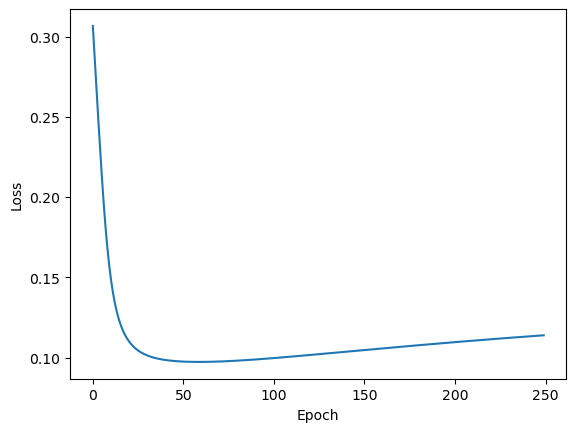

In [144]:
plt.plot(nn.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Observations

| Network    | Value     | Notes     |
|----------------------|-----------|-----------|
| Input layer          | 784 neurons |  |
| Hidden layer         | 200 neurons |  |
| Output layer         | 10 neurons  | Multi-class classification (10 numbers) |
| Hidden layer activation function  | Sigmoid     |  |
| Final layer activation function | Sigmoid |  |
| Loss function        | MSE         |  |
| Learning rate        | 0.0001      | This learning rate gives the least funky plot |
| Epochs               | 250         |  |
| Early stopping point | 60          | Check graph and log |
| Performance          | 0.7         |  |

Improvements that can be made by looking at the architecture of the network:
- Use ReLU instead of Sigmoid for the hidden layers [[1](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)] [[2](https://cs231n.github.io/neural-networks-1/#actfun)]
- Use Softmax instead of Sigmoid for the output layer [[3](https://deepai.org/machine-learning-glossary-and-terms/softmax-layer)]
    - Sigmoid is a special case of Softmax for 2 classes (because it is a probability, that is between 0 and 1)
    - Softmax is a generalization of Sigmoid for multiple classes (because it is a vector of probabilities, that sum to 1)
- Use Cross-entropy loss when using softmax 
    - The derivative of cross-entropy loss with respect to the input of softmax simplifies to the difference between the predicted and actual values
        - Making the network easier to train and often leading to faster convergence. [[3](https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba)]
    - Cross-entropy avoids the vanishing gradient problem that can occur with sigmoid (due to its possible small derivative) [[4](http://neuralnetworksanddeeplearning.com/chap3.html#introducing_the_cross-entropy_cost_function)]